
# Modelo LSTM para Previsão de Tendência - VALE3.SA

**Objetivo:** Este notebook implementa e avalia um modelo de Rede Neural Recorrente (LSTM) para prever a tendência (Compra/Venda) da ação VALE3.SA, com base no comportamento dos preços nos últimos 15 dias.

**Contexto:** Este trabalho faz parte de um desafio para a Cartesius Capital, que busca construir um fundo de ações baseado em modelos de Deep Learning. O modelo visa atuar como um 'perseguidor de tendência'.

**Metodologia:**
1.  **Carregamento de Dados:** Utilização dos arquivos `treino.csv` e `teste.csv` fornecidos, contendo dados históricos da VALE3.SA e rótulos de Compra (+1) / Venda (-1) definidos por economistas.
2.  **Engenharia de Features:** Cálculo de indicadores técnicos (SMAs, EMAs, MACD, RSI, ROC) e features baseadas nos preços dos últimos 15 dias, utilizando apenas a coluna 'Close'.
3.  **Pré-processamento:** Tratamento de valores ausentes (NaNs), escalonamento dos dados (MinMaxScaler) e criação de sequências de 15 dias.
4.  **Modelo LSTM:** Construção de um modelo LSTM com hiperparâmetros otimizados através de busca com Keras Tuner (units=64, dropout=0.3, learning_rate=0.01).
5.  **Treinamento:** Treinamento do modelo com dados de treino, utilizando balanceamento de classes e Early Stopping monitorando a métrica AUC na validação.
6.  **Avaliação:** Análise do desempenho do modelo no conjunto de teste utilizando Acurácia, Matriz de Confusão, Precision, Recall, F1-Score e AUC.
7.  **Visualização:** Geração de gráficos para análise do treinamento, desempenho e comparação das previsões com os preços reais.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates # Para formatar eixos de data
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
# Usar o otimizador Adam padrão ou legacy se necessário
# from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import Adam as LegacyAdam # Usando legacy conforme script original
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from sklearn.utils import class_weight
import os

# Configurações básicas de plotagem e exibição
plt.style.use('fivethirtyeight')
sns.set_theme(style="whitegrid")
pd.set_option('display.max_columns', None)

# --- Configuração do Dispositivo (GPU/MPS/CPU) ---
# (Opcional: Pode ser simplificado ou removido se não for crucial para a apresentação)
print("Configurando dispositivo TensorFlow...")
try:
    if tf.config.list_physical_devices('GPU'):
        print("GPU disponível. Usando TensorFlow com GPU.")
        # Configurações adicionais de GPU podem ser adicionadas aqui se necessário
    elif hasattr(tf.config, 'list_physical_devices') and tf.config.list_physical_devices('MPS'):
         print("Apple MPS disponível. Usando TensorFlow com MPS.")
         # tf.config.experimental.set_visible_devices(tf.config.list_physical_devices('MPS')[0], 'MPS') # Descomente se necessário
    else:
        print("Nenhuma GPU ou MPS detectada. Usando TensorFlow em CPU.")
except Exception as e:
    print(f"Erro ao configurar dispositivos: {e}. Usando configuração padrão.")

Configurando dispositivo TensorFlow...
GPU disponível. Usando TensorFlow com GPU.



## 1. Carregamento dos Dados

Carregamos os conjuntos de dados de treino e teste fornecidos para a ação VALE3.SA. Os dados de treino abrangem o período de 2000 até meados de 2019, e os dados de teste vão de meados de 2019 até o final de 2023.

O índice é definido como a coluna 'Date' e a coluna 'Unnamed: 0' (se existir) é removida.


In [2]:
# Define o diretório dos dados e os caminhos para os arquivos
DATA_DIR = '../data/VALE3.SA/' # Certifique-se que este caminho está correto
TRAIN_PATH = os.path.join(DATA_DIR, 'treino.csv')
TEST_PATH = os.path.join(DATA_DIR, 'teste.csv')

# Tenta carregar os arquivos CSV
try:
    df_train_raw = pd.read_csv(TRAIN_PATH, index_col='Date', parse_dates=True)
    df_test_raw = pd.read_csv(TEST_PATH, index_col='Date', parse_dates=True)
    print(f"Dados de treino carregados. Shape: {df_train_raw.shape}")
    print(f"Dados de teste carregados. Shape: {df_test_raw.shape}")

    # Remove a coluna 'Unnamed: 0' se ela existir
    if 'Unnamed: 0' in df_train_raw.columns:
        df_train_raw = df_train_raw.drop(columns=['Unnamed: 0'])
        print("Coluna 'Unnamed: 0' removida do treino.")
    if 'Unnamed: 0' in df_test_raw.columns:
        df_test_raw = df_test_raw.drop(columns=['Unnamed: 0'])
        print("Coluna 'Unnamed: 0' removida do teste.")

    # Exibe as primeiras linhas e informações básicas
    print("\n--- Amostra Dados Treino ---")
    print(df_train_raw.head())
    print("\n--- Informações Dados Treino ---")
    df_train_raw.info()

    print("\n--- Amostra Dados Teste ---")
    print(df_test_raw.head())
    print("\n--- Informações Dados Teste ---")
    df_test_raw.info()


except FileNotFoundError as e:
    print(f"Erro Crítico: Arquivo não encontrado. Verifique o caminho: {e}")
    # Em um notebook, você pode querer parar a execução aqui ou lidar com o erro
except Exception as e:
    print(f"Erro Crítico: Ocorreu um erro inesperado ao carregar os dados: {e}")

Dados de treino carregados. Shape: (4808, 19)
Dados de teste carregados. Shape: (1203, 19)
Coluna 'Unnamed: 0' removida do treino.
Coluna 'Unnamed: 0' removida do teste.

--- Amostra Dados Treino ---
               Close  Smoothed_Close  Label  Past_1_Days_Close  \
Date                                                             
2000-01-24  1.829122        1.752574      1           1.791015   
2000-01-25  1.829122        1.760229      1           1.829122   
2000-01-26  1.813879        1.765594      1           1.829122   
2000-01-27  1.829122        1.771947      1           1.813879   
2000-01-28  1.829122        1.777664      1           1.829122   

            Past_2_Days_Close  Past_3_Days_Close  Past_4_Days_Close  \
Date                                                                  
2000-01-24           1.829122           1.840554           1.848175   
2000-01-25           1.791015           1.829122           1.840554   
2000-01-26           1.829122           1.791015     


## 2. Engenharia de Features e Definição do Alvo

Nesta etapa, preparamos os dados para o modelo:

1.  **Cálculo de Indicadores Técnicos:** Geramos features relevantes para análise de séries temporais financeiras, utilizando apenas a coluna `Close` (preço de fechamento), pois as colunas OHLCV não estão disponíveis nos arquivos fornecidos. Os indicadores calculados incluem:
    * Retorno Diário (`daily_return`)
    * Médias Móveis Simples (SMA 5, 10, 20, 50)
    * Médias Móveis Exponenciais (EMA 12, 26)
    * Convergência/Divergência da Média Móvel (MACD, Sinal MACD, Histograma MACD)
    * Índice de Força Relativa (RSI)
    * Taxa de Variação (ROC 5, 10, 20)
2.  **Features Baseadas no Histórico:** Criamos features que representam o retorno percentual do preço atual em relação aos preços de 1, 3, 5, 10 e 15 dias anteriores, utilizando as colunas `Past_X_Days_Close`.
3.  **Definição da Variável Alvo (`signal`):** Utilizamos a coluna `Label` fornecida (+1 para Compra, -1 para Venda) e a mapeamos para uma variável binária `signal` (1 para Compra, 0 para Venda), que será o alvo do nosso modelo de classificação.


In [3]:
def calculate_features_and_target_adapted(df):
    """
    Calcula indicadores técnicos possíveis APENAS com a coluna 'Close'
    e usa a coluna 'Label' existente como alvo. Retorna cópia do DataFrame.
    """
    df_copy = df.copy()
    price_col = 'Close' # Usar a coluna 'Close' disponível

    if price_col not in df_copy.columns:
        raise ValueError(f"Coluna '{price_col}' não encontrada.")
    if 'Label' not in df_copy.columns:
        raise ValueError("Coluna 'Label' (alvo) não encontrada.")

    # a) Calcular Retorno Diário
    df_copy['daily_return'] = df_copy[price_col].pct_change() * 100

    # b) Calcular Indicadores Técnicos (Apenas com 'Close')
    print("Calculando indicadores técnicos...")
    # Médias Móveis Simples (SMA)
    for window in [5, 10, 20, 50]:
         df_copy[f'sma_{window}'] = df_copy[price_col].rolling(window=window).mean()

    # Médias Móveis Exponenciais (EMA)
    df_copy['ema_12'] = df_copy[price_col].ewm(span=12, adjust=False).mean()
    df_copy['ema_26'] = df_copy[price_col].ewm(span=26, adjust=False).mean()

    # MACD (calculado a partir das EMAs)
    df_copy['macd'] = df_copy['ema_12'] - df_copy['ema_26']
    df_copy['macd_signal'] = df_copy['macd'].ewm(span=9, adjust=False).mean()
    df_copy['macd_hist'] = df_copy['macd'] - df_copy['macd_signal']

    # RSI (calculado a partir das diferenças de 'Close')
    delta = df_copy[price_col].diff()
    gain = delta.where(delta > 0, 0).fillna(0)
    loss = -delta.where(delta < 0, 0).fillna(0)
    avg_gain = gain.ewm(com=14 - 1, min_periods=14).mean() # Usando EWM
    avg_loss = loss.ewm(com=14 - 1, min_periods=14).mean() # Usando EWM
    rs = avg_gain / avg_loss
    df_copy['rsi'] = 100 - (100 / (1 + rs))
    df_copy['rsi'] = df_copy['rsi'].fillna(50) # Preencher NaNs iniciais do RSI com 50

    # Momentum / ROC (Rate of Change)
    for window in [5, 10, 20]:
        df_copy[f'roc_{window}'] = df_copy[price_col].pct_change(periods=window) * 100

    # Features a partir das colunas Past_X_Days_Close
    print("Calculando features de retorno histórico...")
    past_cols = [col for col in df_copy.columns if col.startswith('Past_') and col.endswith('_Close')]
    for col in past_cols:
        try:
            df_copy[f'return_{col}'] = (df_copy[price_col] / df_copy[col] - 1) * 100
            df_copy[f'return_{col}'] = df_copy[f'return_{col}'].replace([np.inf, -np.inf], np.nan)
        except Exception as e:
            # Em um notebook, é bom avisar sobre erros, mesmo que não parem a execução
            print(f"Aviso: Não foi possível calcular retorno para {col}. Erro: {e}")


    # c) Definir Variável Alvo a partir da coluna 'Label'
    print("Mapeando coluna 'Label' para 'signal' (0/1)...")
    if df_copy['Label'].isin([1, -1]).all():
        df_copy['signal'] = df_copy['Label'].map({1: 1, -1: 0})
    elif df_copy['Label'].isin([1, 0]).all():
         df_copy['signal'] = df_copy['Label']
         print("Aviso: Coluna 'Label' já estava como 1/0.")
    elif df_copy['Label'].isin(['buy', 'sell']).all():
         df_copy['signal'] = df_copy['Label'].map({'buy': 1, 'sell': 0})
    else:
         unique_labels = df_copy['Label'].unique()
         raise ValueError(f"Valores inesperados na coluna 'Label': {unique_labels}. Não foi possível mapear para 0/1.")

    # Remover coluna 'Label' original
    if 'Label' in df_copy.columns:
        df_copy = df_copy.drop(columns=['Label'])

    print("Engenharia de features concluída.")
    return df_copy

# Aplicar a função aos dataframes de treino e teste
df_train_processed = calculate_features_and_target_adapted(df_train_raw)
df_test_processed = calculate_features_and_target_adapted(df_test_raw)

# Exibir amostra dos dados processados
print("\n--- Amostra Dados Treino Processados ---")
print(df_train_processed.head())
print("\n--- Amostra Dados Teste Processados ---")
print(df_test_processed.head())

Calculando indicadores técnicos...
Calculando features de retorno histórico...
Mapeando coluna 'Label' para 'signal' (0/1)...
Engenharia de features concluída.
Calculando indicadores técnicos...
Calculando features de retorno histórico...
Mapeando coluna 'Label' para 'signal' (0/1)...
Engenharia de features concluída.

--- Amostra Dados Treino Processados ---
               Close  Smoothed_Close  Past_1_Days_Close  Past_2_Days_Close  \
Date                                                                         
2000-01-24  1.829122        1.752574           1.791015           1.829122   
2000-01-25  1.829122        1.760229           1.829122           1.791015   
2000-01-26  1.813879        1.765594           1.829122           1.829122   
2000-01-27  1.829122        1.771947           1.813879           1.829122   
2000-01-28  1.829122        1.777664           1.829122           1.813879   

            Past_3_Days_Close  Past_4_Days_Close  Past_5_Days_Close  \
Date                


## 3. Tratamento de Valores Ausentes (NaNs)

Após o cálculo dos indicadores (especialmente médias móveis e ROC com janelas maiores), as primeiras linhas do DataFrame conterão valores NaN. Além disso, o cálculo de `return_Past_X_Days_Close` pode gerar NaNs se o preço passado for zero ou NaN.

1.  **Preenchimento Inicial:** Preenchemos com 0 os NaNs nas colunas `return_Past_X_Days_Close`, assumindo que a ausência de retorno é equivalente a um retorno zero nesses casos específicos.
2.  **Remoção Final:** Removemos todas as linhas restantes que ainda contenham *qualquer* valor NaN. Isso garante que apenas dados completos sejam usados no treinamento e teste, evitando problemas com o modelo e o escalonador.


In [4]:
print("Iniciando tratamento de NaNs...")
initial_train_rows = len(df_train_processed)
initial_test_rows = len(df_test_processed)

# Preencher NaNs específicos das features de retorno histórico com 0
return_past_cols = [col for col in df_train_processed.columns if col.startswith('return_Past_')]
if return_past_cols: # Verifica se a lista não está vazia
    df_train_processed[return_past_cols] = df_train_processed[return_past_cols].fillna(0)
    df_test_processed[return_past_cols] = df_test_processed[return_past_cols].fillna(0)
    print(f"NaNs preenchidos com 0 nas colunas: {return_past_cols}")

# Remover todas as linhas restantes com qualquer NaN
df_train_processed.dropna(inplace=True)
df_test_processed.dropna(inplace=True)

print(f"Linhas removidas do treino por NaNs: {initial_train_rows - len(df_train_processed)}")
print(f"Linhas removidas do teste por NaNs: {initial_test_rows - len(df_test_processed)}")
print(f"Shape treino final após dropna: {df_train_processed.shape}")
print(f"Shape teste final após dropna: {df_test_processed.shape}")

# Verificar se os dataframes não ficaram vazios
if df_train_processed.empty or df_test_processed.empty:
    raise RuntimeError("Erro Crítico: DataFrames ficaram vazios após processamento e remoção de NaNs.")

# Verificar distribuição das classes após limpeza
print("\n--- Distribuição das Classes (Treino Final) ---")
if 'signal' in df_train_processed.columns:
    class_distribution = df_train_processed['signal'].value_counts(normalize=True)
    print(class_distribution)
    # Garantir que a coluna 'signal' é do tipo inteiro
    df_train_processed['signal'] = df_train_processed['signal'].astype(int)
    df_test_processed['signal'] = df_test_processed['signal'].astype(int)
else:
    print("Erro: Coluna 'signal' não encontrada após processamento.")

print("\nVerificação final de NaNs (Treino):", df_train_processed.isna().sum().sum())
print("Verificação final de NaNs (Teste):", df_test_processed.isna().sum().sum())

Iniciando tratamento de NaNs...
NaNs preenchidos com 0 nas colunas: ['return_Past_1_Days_Close', 'return_Past_2_Days_Close', 'return_Past_3_Days_Close', 'return_Past_4_Days_Close', 'return_Past_5_Days_Close', 'return_Past_6_Days_Close', 'return_Past_7_Days_Close', 'return_Past_8_Days_Close', 'return_Past_9_Days_Close', 'return_Past_10_Days_Close', 'return_Past_11_Days_Close', 'return_Past_12_Days_Close', 'return_Past_13_Days_Close', 'return_Past_14_Days_Close', 'return_Past_15_Days_Close']
Linhas removidas do treino por NaNs: 49
Linhas removidas do teste por NaNs: 49
Shape treino final após dropna: (4759, 47)
Shape teste final após dropna: (1154, 47)

--- Distribuição das Classes (Treino Final) ---
signal
0    0.562513
1    0.437487
Name: proportion, dtype: float64

Verificação final de NaNs (Treino): 0
Verificação final de NaNs (Teste): 0



## 4. Seleção de Features e Preparação Final

1.  **Seleção de Features:** Definimos a lista de colunas (`feature_cols`) que serão usadas como entrada para o modelo LSTM. Incluímos os indicadores técnicos calculados, as features de retorno histórico e o próprio preço de fechamento (`Close`).
2.  **Definição do Alvo:** A coluna `signal` é definida como a variável alvo (`target_col`).
3.  **Separação X/y:** Dividimos os DataFrames processados em matrizes de features (X) e vetores de alvo (y) para os conjuntos de treino e teste.


In [5]:
# Lista das features a serem usadas pelo modelo
feature_cols = [
    'daily_return',
    # Indicadores calculados
    'sma_5', 'sma_10', 'sma_20', 'sma_50',
    'ema_12', 'ema_26',
    'macd', 'macd_signal', 'macd_hist',
    'rsi',
    'roc_5', 'roc_10', 'roc_20',
    # Features dos dias passados (retornos relativos)
    'return_Past_1_Days_Close',
    'return_Past_3_Days_Close',
    'return_Past_5_Days_Close',
    'return_Past_10_Days_Close',
    'return_Past_15_Days_Close',
    # Preço de Fechamento
    'Close'
    # 'Smoothed_Close' # Opcional, não usado aqui
]

target_col = 'signal'

# Garantir que todas as features selecionadas existem nos DataFrames
print("\nVerificando existência das features selecionadas...")
available_train_cols = df_train_processed.columns.tolist()
available_test_cols = df_test_processed.columns.tolist()

feature_cols = sorted(list(set([col for col in feature_cols if col in available_train_cols and col in available_test_cols])))

missing_train = [col for col in feature_cols if col not in available_train_cols]
missing_test = [col for col in feature_cols if col not in available_test_cols]

if missing_train:
     raise ValueError(f"ERRO: Features faltando no treino: {missing_train}")
if missing_test:
     raise ValueError(f"ERRO: Features faltando no teste: {missing_test}")

print(f"Features finais selecionadas ({len(feature_cols)}):\n{feature_cols}")

# Separar features (X) e alvo (y)
X_train = df_train_processed[feature_cols]
y_train = df_train_processed[target_col]
X_test = df_test_processed[feature_cols]
y_test = df_test_processed[target_col]

print("\n--- Shapes dos Dados para o Modelo ---")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")


Verificando existência das features selecionadas...
Features finais selecionadas (20):
['Close', 'daily_return', 'ema_12', 'ema_26', 'macd', 'macd_hist', 'macd_signal', 'return_Past_10_Days_Close', 'return_Past_15_Days_Close', 'return_Past_1_Days_Close', 'return_Past_3_Days_Close', 'return_Past_5_Days_Close', 'roc_10', 'roc_20', 'roc_5', 'rsi', 'sma_10', 'sma_20', 'sma_5', 'sma_50']

--- Shapes dos Dados para o Modelo ---
X_train shape: (4759, 20)
y_train shape: (4759,)
X_test shape: (1154, 20)
y_test shape: (1154,)



## 5. Pré-processamento: Escalonamento

Redes neurais geralmente funcionam melhor quando as features de entrada estão em uma escala semelhante. Utilizamos o `MinMaxScaler` do Scikit-learn para escalar todas as features para o intervalo [0, 1].

**Importante:** O escalonador é treinado (`fit_transform`) **apenas** com os dados de treino e depois usado para transformar (`transform`) os dados de teste. Isso evita o *data leakage* (vazamento de informações do conjunto de teste para o treinamento).


In [6]:
print("Aplicando escalonamento MinMaxScaler...")
scaler = MinMaxScaler()

# Treina o scaler com dados de treino e transforma treino
X_train_scaled = scaler.fit_transform(X_train)

# Transforma os dados de teste com o scaler já treinado
X_test_scaled = scaler.transform(X_test)

print("Escalonamento concluído.")
print(f"Shape X_train_scaled: {X_train_scaled.shape}")
print(f"Shape X_test_scaled: {X_test_scaled.shape}")
print(f"Valores Mínimos após escalar (Treino): {X_train_scaled.min(axis=0)}")
print(f"Valores Máximos após escalar (Treino): {X_train_scaled.max(axis=0)}")

Aplicando escalonamento MinMaxScaler...
Escalonamento concluído.
Shape X_train_scaled: (4759, 20)
Shape X_test_scaled: (1154, 20)
Valores Mínimos após escalar (Treino): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Valores Máximos após escalar (Treino): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]



## 6. Pré-processamento: Criação de Sequências Temporais

Modelos LSTM (e outras RNNs/CNNs 1D) requerem que os dados de entrada sejam formatados como sequências temporais. O desafio pede para usar os últimos 15 dias de dados para prever o sinal do dia seguinte.

Criamos uma função `create_sequences` que transforma os dados escalonados em lotes de sequências:
* Cada amostra de entrada (`X_seq`) conterá os dados das features dos últimos `n_steps = 15` dias.
* A saída correspondente (`y_seq`) para cada sequência será o `signal` (0 ou 1) do último dia dessa sequência.

A função também retorna os índices originais do DataFrame correspondentes a cada `y` no conjunto de teste, o que será útil para alinhar as previsões com os preços reais na visualização final.


In [7]:
def create_sequences(X, y, n_steps):
    """
    Cria sequências de dados para modelos temporais.
    Retorna X_seq, y_seq e os índices originais de y.
    """
    if len(X) < n_steps:
        print(f"Aviso: Dados insuficientes ({len(X)} linhas) para criar sequências de tamanho {n_steps}.")
        # Retorna arrays vazios com as dimensões esperadas se possível
        n_features = X.shape[1] if X.ndim == 2 else 0
        return np.empty((0, n_steps, n_features)), np.empty((0,)), np.empty((0,), dtype=y.index.dtype)


    Xs, ys = [], []
    y_indices = [] # Para guardar os índices originais de y
    # Itera para criar as sequências
    for i in range(len(X) - n_steps + 1):
        end_ix = i + n_steps
        Xs.append(X[i:end_ix])
        # O label y corresponde ao ÚLTIMO dia da sequência
        ys.append(y.iloc[end_ix - 1])
        y_indices.append(y.index[end_ix - 1]) # Guarda o índice original de y

    # Verifica se foram criadas sequências antes de converter para NumPy
    if not Xs:
        print("Aviso: Nenhuma sequência foi criada.")
        n_features = X.shape[1] if X.ndim == 2 else 0
        return np.empty((0, n_steps, n_features)), np.empty((0,)), np.empty((0,), dtype=y.index.dtype)

    return np.array(Xs), np.array(ys), np.array(y_indices)

# Define o número de passos temporais (dias) para cada sequência
n_steps = 15
print(f"Criando sequências com n_steps = {n_steps}...")

# Cria as sequências para treino e teste
X_train_seq, y_train_seq, _ = create_sequences(X_train_scaled, y_train, n_steps)
X_test_seq, y_test_seq, y_test_indices = create_sequences(X_test_scaled, y_test, n_steps)

# Verifica se as sequências foram criadas com sucesso
if X_train_seq.size == 0 or X_test_seq.size == 0:
    raise RuntimeError("Erro Crítico: Não foi possível criar as sequências. Verifique os dados.")

print(f"Shape X_train_seq: {X_train_seq.shape}")
print(f"Shape y_train_seq: {y_train_seq.shape}")
print(f"Shape X_test_seq: {X_test_seq.shape}")
print(f"Shape y_test_seq: {y_test_seq.shape}")
print(f"Shape y_test_indices: {y_test_indices.shape}") # Índices para plotagem

Criando sequências com n_steps = 15...
Shape X_train_seq: (4745, 15, 20)
Shape y_train_seq: (4745,)
Shape X_test_seq: (1140, 15, 20)
Shape y_test_seq: (1140,)
Shape y_test_indices: (1140,)



## 7. Balanceamento de Classes

Verificamos a distribuição das classes (0 - Venda, 1 - Compra) no conjunto de treino sequenciado. Se houver desbalanceamento, calculamos pesos para as classes usando `class_weight.compute_class_weight`. Esses pesos serão usados durante o treinamento para dar mais importância à classe minoritária, ajudando o modelo a aprender ambos os padrões de forma mais equilibrada.


In [8]:
print("Calculando pesos das classes para balanceamento...")

# Verifica se há dados e mais de uma classe no target de treino
if len(y_train_seq) > 0 and len(np.unique(y_train_seq)) > 1:
    class_weights = class_weight.compute_class_weight(
        class_weight='balanced',          # Estratégia para calcular pesos
        classes=np.unique(y_train_seq), # Classes únicas presentes (ex: [0, 1])
        y=y_train_seq                     # O vetor de target do treino
    )
    # Cria um dicionário mapeando classe -> peso
    class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
    print(f"Pesos das classes calculados: {class_weight_dict}")
else:
    print("Aviso: Não foi possível calcular pesos (y_train_seq vazio ou contém apenas uma classe).")
    class_weight_dict = None # Não usar pesos se não for possível calcular

Calculando pesos das classes para balanceamento...
Pesos das classes calculados: {0: 0.8879116766467066, 1: 1.1444766039556198}



## 8. Construção do Modelo LSTM Otimizado

Construímos o modelo LSTM utilizando a biblioteca Keras. A arquitetura e os hiperparâmetros foram definidos com base nos resultados da otimização realizada com Keras Tuner:

* **Camada LSTM:** A camada principal que processa as sequências temporais.
    * `units=64`: Número de neurônios na camada LSTM (otimizado).
    * `input_shape=(n_steps, n_features)`: Define o formato da entrada (15 dias, número de features).
    * `recurrent_dropout=0.3`: Taxa de dropout aplicada às conexões recorrentes (ajudou na otimização, pode ser diferente do dropout normal).
    * `return_sequences=False`: Retorna apenas a saída do último passo da sequência, pois a próxima camada é Densa.
* **Camada Dropout:** Regularização para prevenir overfitting.
    * `rate=0.3`: Taxa de dropout (otimizada).
* **Camada Dense (Saída):** Camada final para classificação binária.
    * `units=1`: Um neurônio para a saída binária.
    * `activation='sigmoid'`: Função de ativação adequada para classificação binária (saída entre 0 e 1).

Utilizamos o otimizador `Adam` (versão `legacy` conforme script original, pode ser trocado pelo Adam padrão) com a taxa de aprendizado otimizada (`learning_rate=0.01`). A função de perda é `binary_crossentropy` e monitoramos `accuracy` e `AUC` durante o treinamento.


In [9]:
print("Construindo o modelo LSTM com hiperparâmetros otimizados...")

# Verifica se há dados de treino para obter n_features
if X_train_seq.size > 0:
    n_features = X_train_seq.shape[2] # Número de features na entrada
    print(f"Número de features de entrada: {n_features}")

    # Hiperparâmetros otimizados (obtidos do tuning anterior)
    OPTIMIZED_UNITS = 64
    OPTIMIZED_DROPOUT = 0.3
    OPTIMIZED_LR = 0.01
    # OPTIMIZED_RECURRENT_DROPOUT = 0.3 # Usando o valor do script original, mas poderia ser otimizado

    # Construção do modelo Sequencial
    model = Sequential(name="LSTM_Otimizado_VALE3")
    model.add(LSTM(units=OPTIMIZED_UNITS,
                   input_shape=(n_steps, n_features),
                   recurrent_dropout=OPTIMIZED_DROPOUT, # Usando dropout otimizado aqui também
                   return_sequences=False,
                   name='lstm_layer_otimizada'))
    model.add(Dropout(OPTIMIZED_DROPOUT, name='dropout_otimizado')) # Dropout após LSTM
    model.add(Dense(1, activation='sigmoid', name='output_layer')) # Camada de saída

    # Exibe o resumo da arquitetura do modelo
    model.summary()

else:
    raise RuntimeError("Erro: X_train_seq está vazio, não é possível construir o modelo.")

print("\nCompilando o modelo...")
# Compila o modelo com o otimizador e taxa de aprendizado otimizados
model.compile(
    optimizer=LegacyAdam(learning_rate=OPTIMIZED_LR), # Usando Adam legacy e LR otimizada
    loss='binary_crossentropy',                        # Função de perda para classificação binária
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')] # Métricas para monitorar
)
print("Modelo compilado com sucesso.")

Construindo o modelo LSTM com hiperparâmetros otimizados...
Número de features de entrada: 20


2025-04-26 11:37:26.099405: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-04-26 11:37:26.099645: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-04-26 11:37:26.099664: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-04-26 11:37:26.100303: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-26 11:37:26.100636: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "LSTM_Otimizado_VALE3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_layer_otimizada (LSTM  (None, 64)                21760     
 )                                                               
                                                                 
 dropout_otimizado (Dropout  (None, 64)                0         
 )                                                               
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 21825 (85.25 KB)
Trainable params: 21825 (85.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Compilando o modelo...
Modelo compilado com sucesso.



## 9. Treinamento do Modelo

Treinamos o modelo LSTM compilado utilizando os dados de treino sequenciados (`X_train_seq`, `y_train_seq`).

* **Épocas:** Definimos um número máximo de épocas (`epochs=50`), mas usamos `EarlyStopping`.
* **Batch Size:** Tamanho do lote usado em cada atualização dos pesos (`batch_size=64`).
* **Validação:** Usamos os dados de teste sequenciados (`X_test_seq`, `y_test_seq`) como conjunto de validação para monitorar o desempenho do modelo em dados não vistos durante o treinamento.
* **Early Stopping:** Interrompemos o treinamento se a métrica `val_auc` (AUC na validação) não melhorar por um número definido de épocas (`patience=10`), restaurando os pesos do modelo da época com o melhor desempenho. Isso ajuda a evitar overfitting e economiza tempo de treinamento.
* **Pesos de Classe:** Aplicamos os `class_weight_dict` calculados anteriormente para lidar com o desbalanceamento de classes.


In [10]:
# Parâmetros de treinamento
EPOCHS = 50
BATCH_SIZE = 64

# Configuração do Early Stopping
early_stopping = EarlyStopping(
    monitor='val_auc',      # Métrica a ser monitorada (AUC na validação)
    patience=10,            # Número de épocas sem melhora para parar
    mode='max',             # Queremos maximizar a AUC
    restore_best_weights=True, # Restaura os pesos do melhor epoch
    verbose=1               # Mostra mensagens quando parar
)

print(f"Iniciando o treinamento por até {EPOCHS} épocas...")

# Treina o modelo
history = model.fit(
    X_train_seq,            # Features de treino sequenciadas
    y_train_seq,            # Target de treino sequenciado
    epochs=EPOCHS,          # Número máximo de épocas
    batch_size=BATCH_SIZE,  # Tamanho do lote
    validation_data=(X_test_seq, y_test_seq), # Dados para validação
    callbacks=[early_stopping],             # Callback para parar cedo
    class_weight=class_weight_dict,         # Pesos para balancear classes (se aplicável)
    verbose=1                               # Mostrar progresso (1 para barra de progresso)
)

print("Treinamento concluído.")

# Opcional: Exibir as métricas do histórico
# print("\nHistórico de Treinamento:")
# hist_df = pd.DataFrame(history.history)
# print(hist_df)

Iniciando o treinamento por até 50 épocas...
Epoch 1/50


2025-04-26 11:38:04.477212: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


75/75 [==============================] - ETA: 0s - loss: 0.4935 - accuracy: 0.7496 - auc: 0.8469

2025-04-26 11:38:33.731429: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


75/75 [==============================] - 31s 391ms/step - loss: 0.4935 - accuracy: 0.7496 - auc: 0.8469 - val_loss: 0.2741 - val_accuracy: 0.8763 - val_auc: 0.9752
Epoch 2/50
75/75 [==============================] - 29s 380ms/step - loss: 0.2813 - accuracy: 0.8805 - auc: 0.9532 - val_loss: 0.2665 - val_accuracy: 0.8816 - val_auc: 0.9745
Epoch 3/50
75/75 [==============================] - 29s 385ms/step - loss: 0.2357 - accuracy: 0.8991 - auc: 0.9667 - val_loss: 0.1821 - val_accuracy: 0.9281 - val_auc: 0.9824
Epoch 4/50
75/75 [==============================] - 29s 384ms/step - loss: 0.2050 - accuracy: 0.9123 - auc: 0.9743 - val_loss: 0.1817 - val_accuracy: 0.9246 - val_auc: 0.9847
Epoch 5/50
75/75 [==============================] - 29s 381ms/step - loss: 0.2210 - accuracy: 0.9016 - auc: 0.9701 - val_loss: 0.2237 - val_accuracy: 0.8904 - val_auc: 0.9798
Epoch 6/50
75/75 [==============================] - 29s 381ms/step - loss: 0.1966 - accuracy: 0.9130 - auc: 0.9765 - val_loss: 0.2103 - 


## 10. Avaliação do Desempenho

Após o treinamento, avaliamos o desempenho do modelo final (com os melhores pesos restaurados pelo Early Stopping) no conjunto de teste, que o modelo nunca viu durante o treinamento ou a otimização.

1.  **Métricas Gerais:** Usamos `model.evaluate()` para obter a Perda (Loss), Acurácia e AUC no conjunto de teste.
2.  **Previsões:** Geramos as previsões de probabilidade (`y_pred_proba`) para o conjunto de teste.
3.  **Classificação:** Convertemos as probabilidades em classes binárias (0 ou 1) usando um limiar padrão de 0.5 (`y_pred`).
4.  **Matriz de Confusão:** Visualizamos a performance detalhada da classificação (Verdadeiros Positivos/Negativos, Falsos Positivos/Negativos).
5.  **Relatório de Classificação:** Calculamos Precision, Recall e F1-Score para cada classe (Compra e Venda).
6.  **AUC Score:** Calculamos novamente o AUC a partir das probabilidades previstas para confirmação.


Avaliando o modelo treinado no conjunto de teste...

--- Resultados da Avaliação (evaluate) ---
Perda (Loss): 0.1831
Acurácia: 0.9175 (91.75%)
AUC (da evaluate): 0.9868

Gerando previsões no conjunto de teste...


2025-04-26 11:50:46.465844: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Usando limiar padrão: 0.50 para classificação.

--- Matriz de Confusão ---


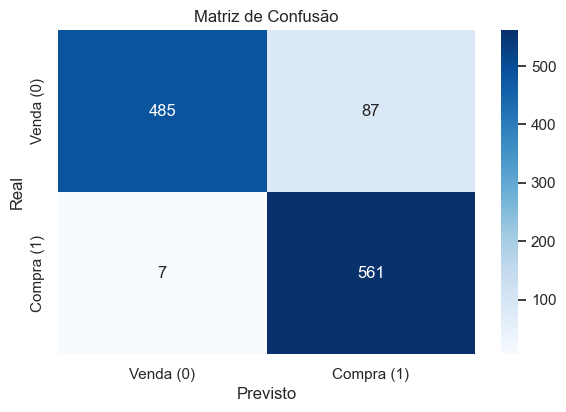


--- Relatório de Classificação ---
              precision    recall  f1-score   support

   Venda (0)       0.99      0.85      0.91       572
  Compra (1)       0.87      0.99      0.92       568

    accuracy                           0.92      1140
   macro avg       0.93      0.92      0.92      1140
weighted avg       0.93      0.92      0.92      1140


--- AUC Score ---
AUC Score (calculado via roc_auc_score): 0.9869


In [11]:

print("Avaliando o modelo treinado no conjunto de teste...")

# Avalia o modelo usando o método evaluate
results = model.evaluate(X_test_seq, y_test_seq, verbose=0, batch_size=BATCH_SIZE*2) # Batch maior para avaliação
loss = results[0]
accuracy = results[1]
auc_metric = results[2] # AUC calculado pelo Keras durante evaluate

print(f"\n--- Resultados da Avaliação (evaluate) ---")
print(f"Perda (Loss): {loss:.4f}")
print(f"Acurácia: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"AUC (da evaluate): {auc_metric:.4f}")

# Gera previsões de probabilidade para o conjunto de teste
print("\nGerando previsões no conjunto de teste...")
y_pred_proba = model.predict(X_test_seq, batch_size=BATCH_SIZE*2, verbose=0).flatten()

# Converte probabilidades em classes usando limiar 0.5
threshold = 0.5
y_pred = (y_pred_proba >= threshold).astype(int)
print(f"Usando limiar padrão: {threshold:.2f} para classificação.")

# Criar DataFrame com resultados para facilitar análise e plotagem posterior
# Usa os índices guardados durante a criação das sequências
results_df = pd.DataFrame({
    'Actual': y_test_seq,      # Valores reais (0 ou 1)
    'Predicted': y_pred,       # Valores previstos (0 ou 1)
    'Probability': y_pred_proba # Probabilidade prevista (entre 0 e 1)
}, index=y_test_indices)

# Junta com os dados originais de teste para ter acesso ao preço 'Close'
# Garante que estamos pegando apenas as linhas correspondentes às previsões
plot_df = df_test_processed.loc[results_df.index].copy()
plot_df = plot_df.join(results_df)


# Calcula e exibe a Matriz de Confusão
print("\n--- Matriz de Confusão ---")
cm = confusion_matrix(y_test_seq, y_pred)
# Para melhor visualização no notebook, podemos usar seaborn heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Venda (0)', 'Compra (1)'], yticklabels=['Venda (0)', 'Compra (1)'])
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()
# print(cm) # Impressão textual opcional

# Calcula e exibe o Relatório de Classificação
print("\n--- Relatório de Classificação ---")
report = classification_report(y_test_seq, y_pred, target_names=['Venda (0)', 'Compra (1)'], zero_division=0)
print(report)

# Calcula e exibe o AUC Score a partir das probabilidades
print("\n--- AUC Score ---")
try:
    roc_auc_score_val = roc_auc_score(y_test_seq, y_pred_proba)
    print(f"AUC Score (calculado via roc_auc_score): {roc_auc_score_val:.4f}")
except ValueError as e:
     print(f"Não foi possível calcular AUC score: {e}") # Caso só haja uma classe
except Exception as e:
    print(f"Erro ao calcular AUC Score: {e}")



## 11. Visualização dos Resultados

Gráficos ajudam a entender melhor o processo de treinamento e o desempenho do modelo:

1.  **Histórico de Treinamento:** Plotamos a Acurácia, Perda (Loss) e AUC ao longo das épocas, tanto para o conjunto de treino quanto para o de validação. Isso ajuda a identificar overfitting e a convergência do modelo.
2.  **Curva ROC:** Mostra a capacidade do modelo de distinguir entre as classes em diferentes limiares de classificação. A área sob a curva (AUC) quantifica essa capacidade.
3.  **Distribuição das Probabilidades:** Um histograma das probabilidades previstas pelo modelo no conjunto de teste. Idealmente, as probabilidades para as classes reais 0 e 1 devem estar bem separadas.
4.  **Preço Real vs. Sinais Previstos:** Um gráfico crucial que plota o preço de fechamento real da ação no período de teste e sobrepõe marcadores indicando os sinais de Compra (verde) e Venda (vermelho) previstos pelo modelo. Isso dá uma visão intuitiva de como as previsões se alinham (ou não) com os movimentos do mercado.


Gerando gráficos de visualização...
Plotando histórico de treinamento...


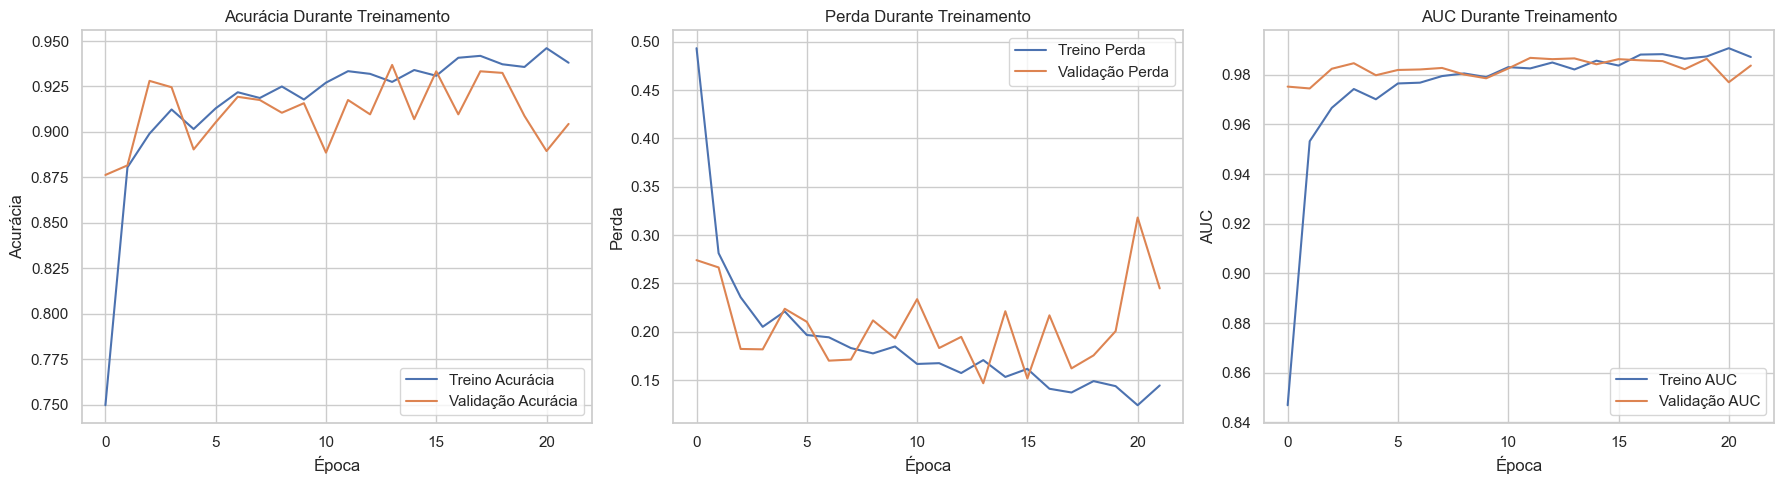

Plotando Curva ROC...


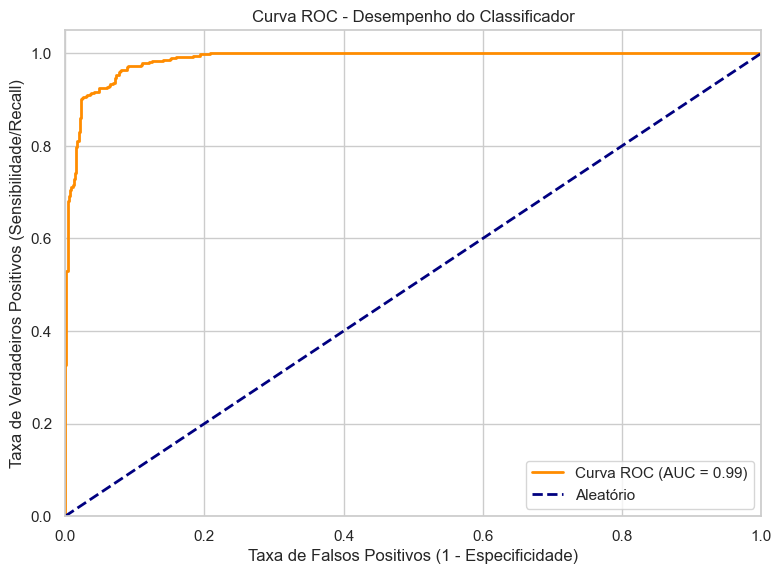

Plotando distribuição das probabilidades...


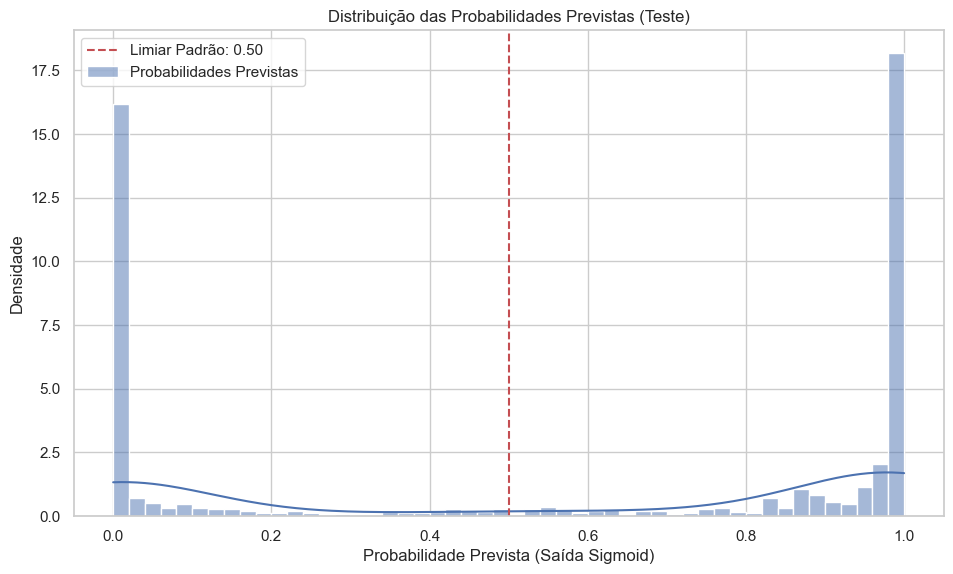

Plotando gráfico de Preço vs. Sinais Previstos...


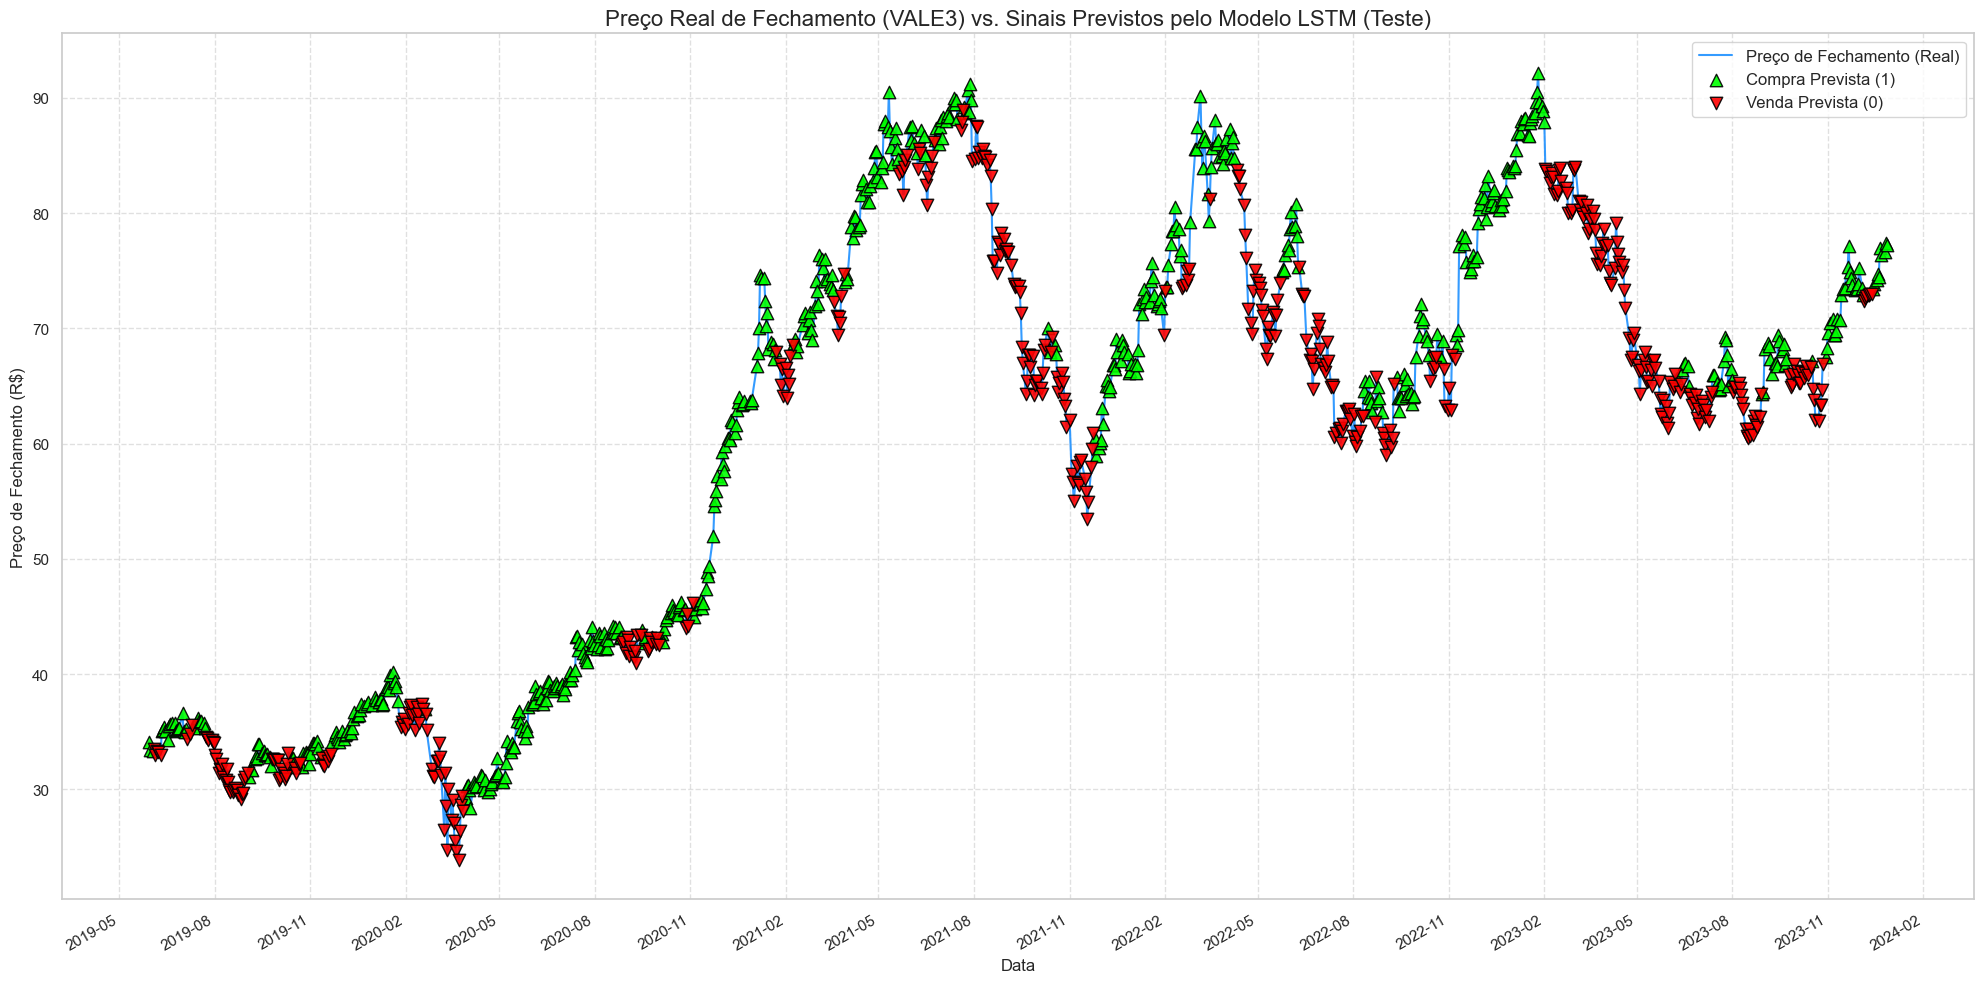

In [12]:
print("Gerando gráficos de visualização...")

# 1. Gráficos do Histórico de Treinamento
if history and history.history:
    print("Plotando histórico de treinamento...")
    plt.figure(figsize=(18, 5))
    metrics_to_plot = {'Acurácia': 'accuracy', 'Perda': 'loss', 'AUC': 'auc'}
    i = 1
    for display_name, metric_key in metrics_to_plot.items():
        # Verifica se a métrica existe no histórico
        if metric_key in history.history:
            plt.subplot(1, len(metrics_to_plot), i)
            plt.plot(history.history[metric_key], label=f'Treino {display_name}')
            val_metric_key = f'val_{metric_key}'
            # Verifica se a métrica de validação existe
            if val_metric_key in history.history:
                plt.plot(history.history[val_metric_key], label=f'Validação {display_name}')
            plt.title(f'{display_name} Durante Treinamento')
            plt.xlabel('Época')
            plt.ylabel(display_name)
            plt.legend()
            i += 1
    plt.tight_layout()
    plt.savefig('lstm_vale3_training_metrics.png') # Salva o gráfico
    plt.show()
else:
    print("Histórico de treinamento não disponível para plotagem.")

# 2. Gráfico da Curva ROC
# Só faz sentido plotar se houver ambas as classes no conjunto de teste
if len(np.unique(y_test_seq)) > 1:
    print("Plotando Curva ROC...")
    plt.figure(figsize=(8, 6))
    try:
        fpr, tpr, thresholds = roc_curve(y_test_seq, y_pred_proba)
        roc_auc = auc(fpr, tpr) # Calcula a área sob a curva
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aleatório') # Linha de referência
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Taxa de Falsos Positivos (1 - Especificidade)')
        plt.ylabel('Taxa de Verdadeiros Positivos (Sensibilidade/Recall)')
        plt.title('Curva ROC - Desempenho do Classificador')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.savefig('lstm_vale3_roc_curve.png') # Salva o gráfico
        plt.show()
    except Exception as e:
        print(f"Erro ao gerar curva ROC: {e}")
else:
    print("Curva ROC não gerada (necessita de ambas as classes no conjunto de teste).")

# 3. Gráfico da Distribuição das Probabilidades Previstas
print("Plotando distribuição das probabilidades...")
plt.figure(figsize=(10, 6))
# Plota o histograma das probabilidades previstas para o conjunto de teste
sns.histplot(y_pred_proba, bins=50, kde=True, label='Probabilidades Previstas', stat='density')
# Adiciona linhas verticais para o limiar e talvez médias das classes
plt.axvline(x=threshold, color='r', linestyle='--', label=f'Limiar Padrão: {threshold:.2f}')
# plt.axvline(x=y_pred_proba[y_test_seq==0].mean(), color='orange', linestyle=':', label='Média Prob. Venda Real')
# plt.axvline(x=y_pred_proba[y_test_seq==1].mean(), color='blue', linestyle=':', label='Média Prob. Compra Real')
plt.title('Distribuição das Probabilidades Previstas (Teste)')
plt.xlabel('Probabilidade Prevista (Saída Sigmoid)')
plt.ylabel('Densidade')
plt.legend()
plt.savefig('lstm_vale3_prediction_distribution.png') # Salva o gráfico
plt.show()

# 4. Gráfico de Preço Real vs. Sinais Previstos
print("Plotando gráfico de Preço vs. Sinais Previstos...")
plt.figure(figsize=(20, 10)) # Gráfico maior para melhor visualização da série temporal

# Plotar o preço de fechamento real do período de teste correspondente às previsões
plt.plot(plot_df.index, plot_df['Close'], label='Preço de Fechamento (Real)', color='dodgerblue', alpha=0.9, linewidth=1.5, zorder=1)

# Identificar os pontos de compra e venda previstos no DataFrame `plot_df`
buy_signals = plot_df[plot_df['Predicted'] == 1]
sell_signals = plot_df[plot_df['Predicted'] == 0]

# Plotar marcadores para os sinais previstos sobre a linha de preço
# Usar 'o' (círculo) ou '^'/'v' (triângulos) com tamanho ajustado (s)
plt.scatter(buy_signals.index, buy_signals['Close'], label='Compra Prevista (1)', marker='^', color='lime', s=80, edgecolor='black', alpha=0.9, zorder=3)
plt.scatter(sell_signals.index, sell_signals['Close'], label='Venda Prevista (0)', marker='v', color='red', s=80, edgecolor='black', alpha=0.9, zorder=3)

plt.title('Preço Real de Fechamento (VALE3) vs. Sinais Previstos pelo Modelo LSTM (Teste)', fontsize=16)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Preço de Fechamento (R$)', fontsize=12)

# Melhorar formatação do eixo X para datas
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) # Formato Ano-Mês
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3)) # Ticks a cada 3 meses
plt.gcf().autofmt_xdate() # Rotaciona as datas

plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout() # Ajusta o layout para não cortar labels
plt.savefig('lstm_vale3_price_vs_predictions.png') # Salva o gráfico
plt.show()


## 12. Salvamento do Modelo

Finalmente, salvamos o modelo treinado no formato recomendado `.keras`. Isso permite que o modelo seja carregado posteriormente para fazer novas previsões ou para análise adicional sem a necessidade de retreinamento.


In [13]:
print("Salvando o modelo treinado...")
MODEL_SAVE_PATH = 'models/vale3_lstm_model.keras'
H5_SAVE_PATH = 'models/vale3_lstm_model.h5' # Fallback

try:
    # Cria o diretório 'models' se ele não existir
    os.makedirs('models', exist_ok=True)

    # Salva o modelo no formato nativo do Keras
    model.save(MODEL_SAVE_PATH)
    print(f"Modelo salvo com sucesso em '{MODEL_SAVE_PATH}'")

except Exception as e:
    print(f"Erro ao salvar o modelo no formato Keras: {e}")
    # Tenta salvar no formato HDF5 como fallback
    try:
        model.save(H5_SAVE_PATH)
        print(f"Modelo salvo no formato HDF5 em '{H5_SAVE_PATH}'")
    except Exception as e2:
        print(f"Erro ao salvar o modelo no formato HDF5: {e2}")

Salvando o modelo treinado...
Modelo salvo com sucesso em 'models/vale3_lstm_model.keras'
